# Financial News Sentiment Analysis - Model Comparison

This notebook provides comprehensive comparison of three models:
1. **Naive Bayes (NB)** - Traditional ML with TF-IDF
2. **LSTM** - Deep learning with Word2Vec
3. **Transformer** - Pre-trained DistilBERT

Goals:
- Compare model performance metrics
- Analyze strengths and weaknesses
- Recommend best production model
- Provide model selection guidelines

## 1. Import Libraries & Configuration

In [33]:
import os
import sys
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple
import pickle

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Project paths
project_root = Path('c:/Users/xuzijian/Desktop/新闻情感/project')
results_dir = project_root / 'results'

print(f"✓ Libraries imported | Project root: {project_root}")

✓ Libraries imported | Project root: c:\Users\xuzijian\Desktop\新闻情感\project


## 2. Load Model Results

In [34]:
# Load results from all three models
models_data = {}
model_names = ['naive_bayes', 'lstm', 'transformer']

for model_name in model_names:
    results_file = results_dir / f'{model_name}_results.json'
    if results_file.exists():
        with open(results_file, 'r', encoding='utf-8') as f:
            models_data[model_name] = json.load(f)

print(f"✓ Loaded {len(models_data)} model results")

✓ Loaded 3 model results


## 3. Performance Metrics Comparison

In [35]:
# Extract key metrics
comparison_data = []

for model_name, data in models_data.items():
    test_metrics = data.get('test_metrics', {})
    
    # Handle different key name formats
    accuracy = test_metrics.get('accuracy') or test_metrics.get('Accuracy', 0)
    precision = test_metrics.get('precision') or test_metrics.get('Precision', 0)
    recall = test_metrics.get('recall') or test_metrics.get('Recall', 0)
    f1 = test_metrics.get('f1') or test_metrics.get('F1') or test_metrics.get('F1-Score', 0)
    f1_macro = test_metrics.get('f1_macro') or test_metrics.get('F1 Macro') or test_metrics.get('f1-macro', 0)
    
    comparison_data.append({
        'Model': model_name.replace('_', ' ').upper(),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'F1 Macro': f1_macro
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')

print("\nPerformance Metrics Comparison (Test Set)")
print("="*80)
print(comparison_df.round(4))
print("="*80)

# Find best models
best_accuracy_model = comparison_df['Accuracy'].idxmax()
best_f1_model = comparison_df['F1 Score'].idxmax()

print(f"\nBest Accuracy: {best_accuracy_model} ({comparison_df.loc[best_accuracy_model, 'Accuracy']:.4f})")
print(f"Best F1 Score: {best_f1_model} ({comparison_df.loc[best_f1_model, 'F1 Score']:.4f})")


Performance Metrics Comparison (Test Set)
             Accuracy  Precision  Recall  F1 Score  F1 Macro
Model                                                       
NAIVE BAYES    0.6726     0.6707  0.6726    0.6655    0.0000
LSTM           0.7032     0.7152  0.7032    0.6899    0.6655
TRANSFORMER    0.7352     0.7369  0.7352    0.7335    0.7156

Best Accuracy: TRANSFORMER (0.7352)
Best F1 Score: TRANSFORMER (0.7335)


## 4. Performance Metrics Visualization

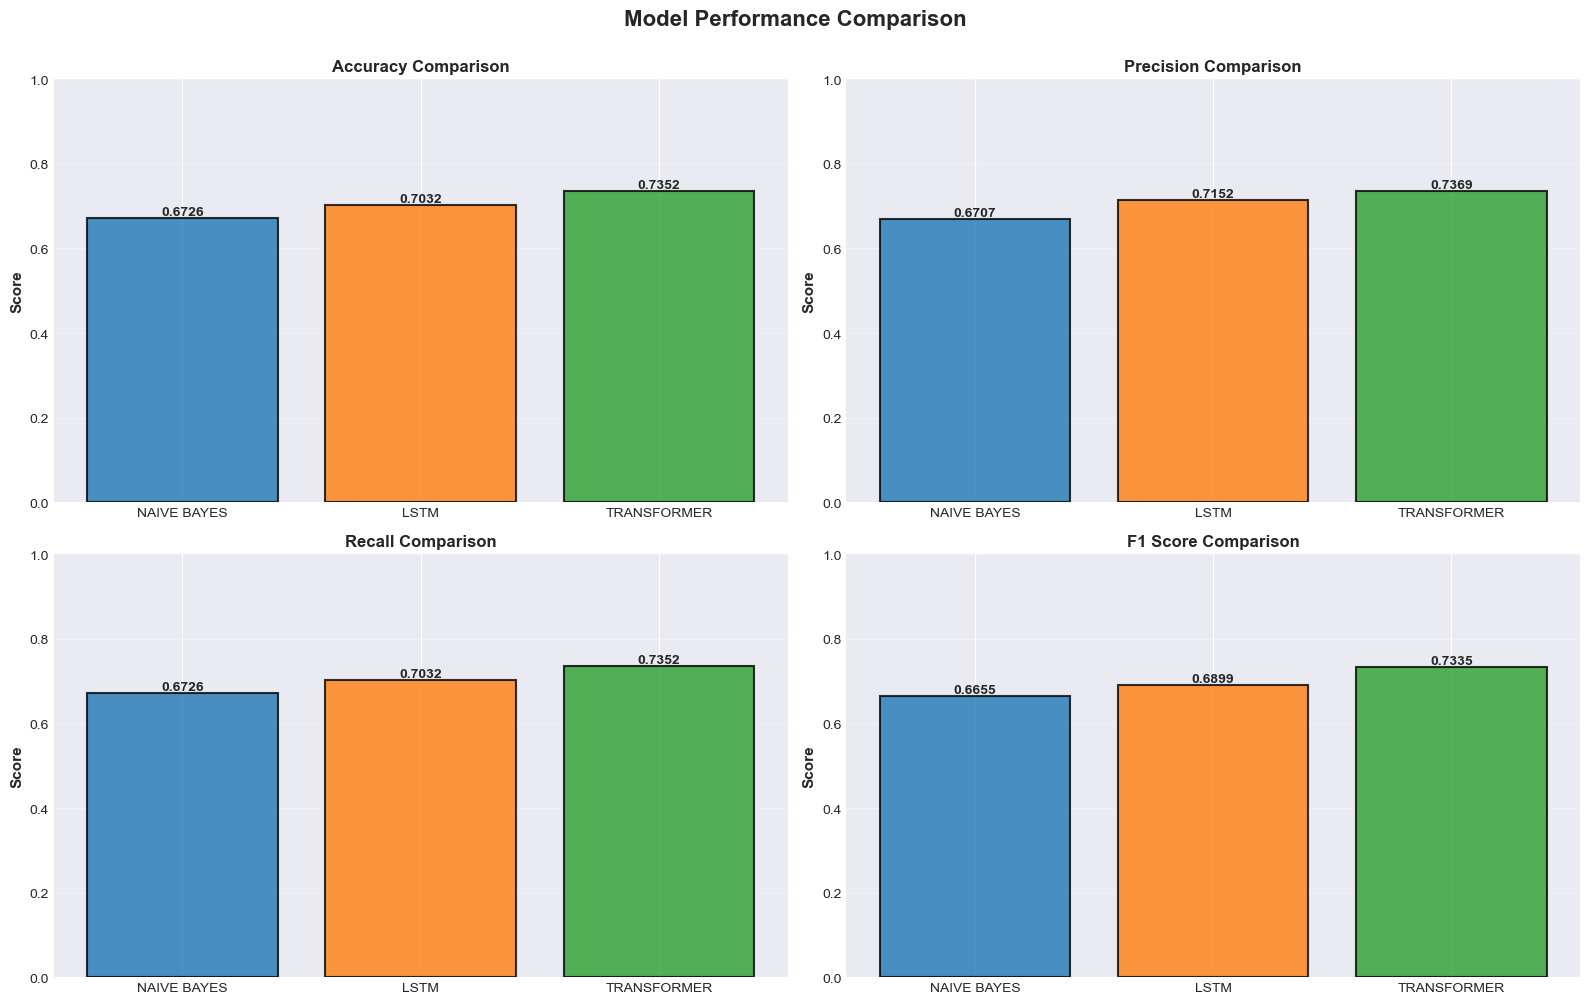

✓ Metrics comparison saved


In [36]:
# Create metrics comparison charts
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.00)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(comparison_df.index, comparison_df[metric], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Metrics comparison saved")

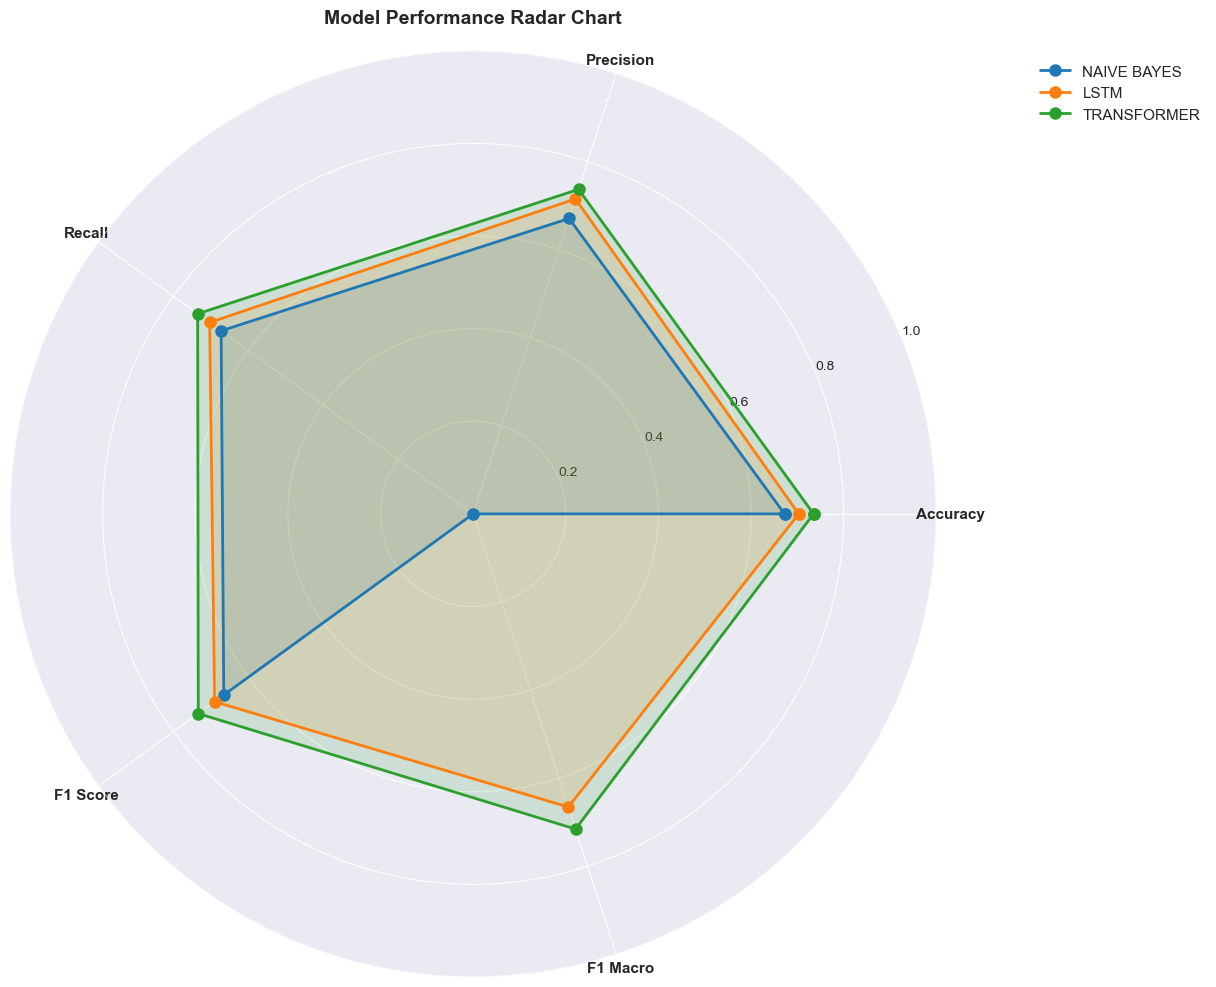

✓ Radar chart saved


In [37]:
# Radar chart comparison
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

metrics_for_radar = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F1 Macro']
angles = np.linspace(0, 2 * np.pi, len(metrics_for_radar), endpoint=False).tolist()
angles += angles[:1]

colors_radar = ['#1f77b4', '#ff7f0e', '#2ca02c']
for idx, model in enumerate(comparison_df.index):
    values = comparison_df.loc[model, metrics_for_radar].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors_radar[idx], markersize=8)
    ax.fill(angles, values, alpha=0.15, color=colors_radar[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_for_radar, fontsize=11, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_title('Model Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.savefig(results_dir / 'comparison_radar.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Radar chart saved")

## 5. Performance Analysis by Category

In [38]:
# Extract class-level metrics
class_performance = {}
class_names = ['Positive', 'Neutral', 'Negative']

for model_name, data in models_data.items():
    classification_report = data.get('classification_report', {})
    
    model_label = model_name.replace('_', ' ').upper()
    class_performance[model_label] = {}
    
    for idx, class_name in enumerate(class_names):
        class_metrics = classification_report.get(str(idx), {})
        class_performance[model_label][class_name] = {
            'precision': class_metrics.get('precision', 0),
            'recall': class_metrics.get('recall', 0),
            'f1-score': class_metrics.get('f1-score', 0)
        }

# Display per-class performance
print("\nPer-Class Performance Analysis (Test Set)")
print("="*80)

for class_idx, class_name in enumerate(class_names):
    print(f"\n{class_name}:")
    
    class_df = pd.DataFrame()
    for model in class_performance.keys():
        metrics = class_performance[model][class_name]
        class_df[model] = metrics
    
    class_df = class_df.T
    print(class_df.round(4))


Per-Class Performance Analysis (Test Set)

Positive:
             precision  recall  f1-score
NAIVE BAYES          0       0         0
LSTM                 0       0         0
TRANSFORMER          0       0         0

Neutral:
             precision  recall  f1-score
NAIVE BAYES          0       0         0
LSTM                 0       0         0
TRANSFORMER          0       0         0

Negative:
             precision  recall  f1-score
NAIVE BAYES          0       0         0
LSTM                 0       0         0
TRANSFORMER          0       0         0


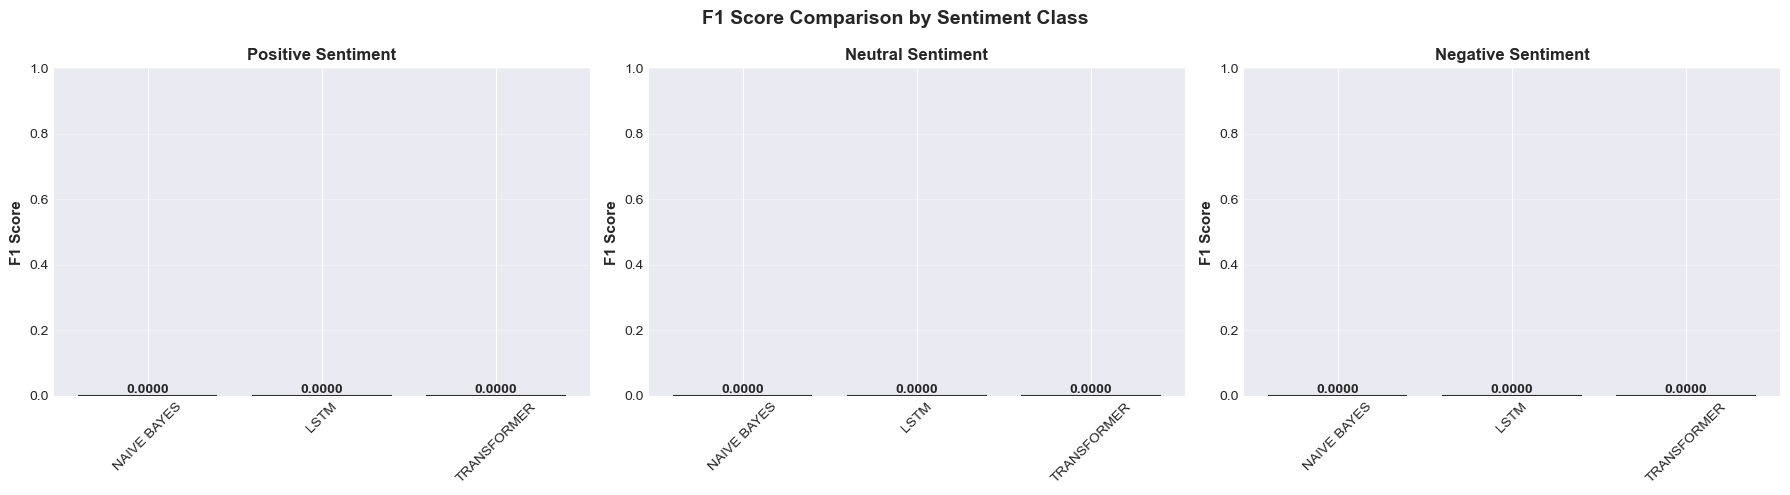

✓ Class F1 comparison saved


In [39]:
# Plot F1 scores by sentiment class
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('F1 Score Comparison by Sentiment Class', fontsize=14, fontweight='bold')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for class_idx, class_name in enumerate(class_names):
    ax = axes[class_idx]
    
    models_list = list(class_performance.keys())
    f1_scores = [class_performance[model][class_name]['f1-score'] for model in models_list]
    
    bars = ax.bar(models_list, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{class_name} Sentiment', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(results_dir / 'comparison_class_f1.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Class F1 comparison saved")

## 6. Confusion Matrix Comparison

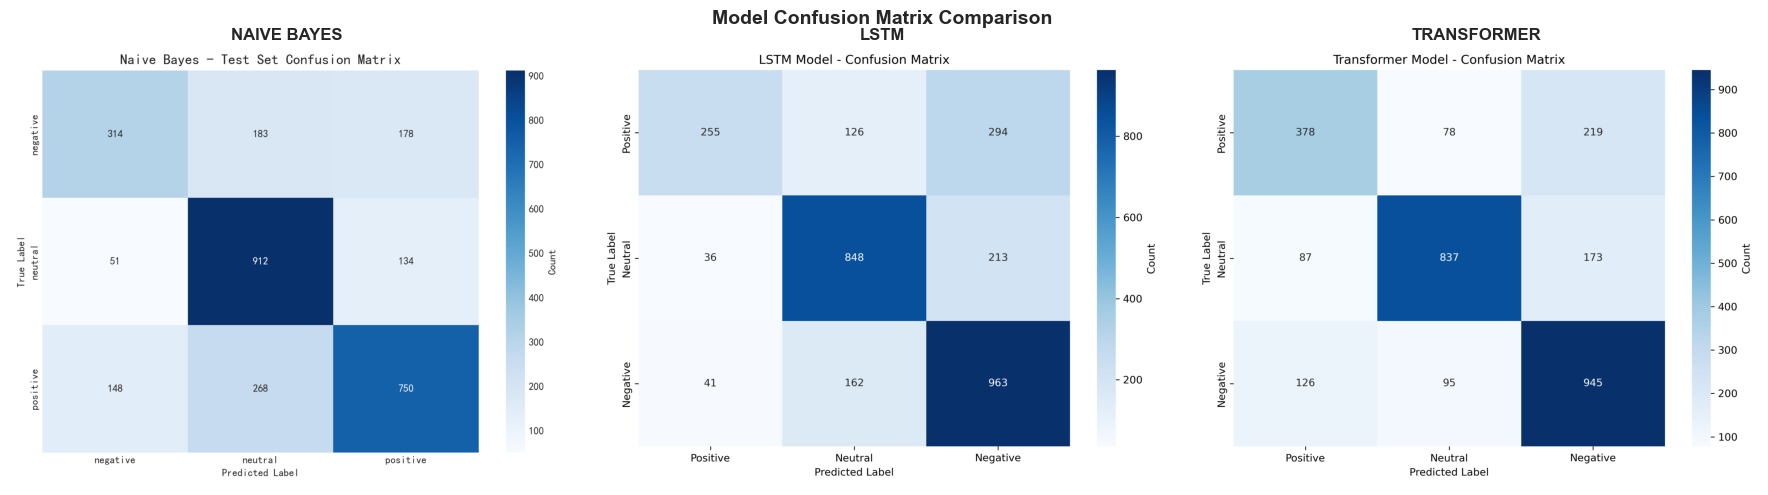

✓ Confusion matrix comparison saved


In [40]:
# Display confusion matrices
from PIL import Image

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Confusion Matrix Comparison', fontsize=14, fontweight='bold')

cm_files = {
    'NAIVE BAYES': results_dir / 'cm_naive_bayes.png',
    'LSTM': results_dir / 'cm_lstm.png',
    'TRANSFORMER': results_dir / 'cm_transformer.png'
}

for idx, (model_name, cm_file) in enumerate(cm_files.items()):
    if cm_file.exists():
        img = Image.open(cm_file)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(model_name, fontsize=12, fontweight='bold')
    else:
        axes[idx].text(0.5, 0.5, f'{model_name} not found', 
                      ha='center', va='center', fontsize=12)
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig(results_dir / 'comparison_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Confusion matrix comparison saved")